In [1]:
from src.utils.myOptimization import (
    AlphaFairnesstorch,
    solveIndProblem, solve_closed_form, solve_group, compute_coupled_group_obj
)
from src.utils.myPrediction import generate_random_features, customPredictionModel
from src.utils.plots import visLearningCurve
from src.fairness.cal_fair_penalty import atkinson_loss, mean_abs_dev, compute_fairness_grad,mean_abs_dev, compute_group_accuracy_parity

import numpy as np
import cvxpy as cp
import torch
import torch.nn as nn
import pandas as pd

from src.utils.features import get_all_features
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Define Alpha & Q

In [2]:
# Save to json
import json
params = {
    "n_sample": 5000 ,
    "alpha": 2,
    "Q": 2500,
    "epochs": 100,
    "lambdas": 1.0,
    "lr": 0.01
}

# with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "w") as f:
#     json.dump(params, f, indent=4)

# import json

# with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "r") as f:
#     params = json.load(f)

n_sample = params["n_sample"]
alpha    = params["alpha"]
Q        = params["Q"]
epochs   = params["epochs"]
lambdas  = params["lambdas"]
lr       = params["lr"]


In [3]:
df = pd.read_csv('E:\\myREPO\\Fairness-Decision-Focused-Loss\\Organized-FDFL\\src\\data\\data.csv')
df = df.sample(n=n_sample,random_state=42)

# Normalized cost to 0.1-10 range
cost = np.array(df['cost_t_capped'].values) * 100
cost = np.maximum(cost, 1)

# All features, standardized
features = df[get_all_features(df)].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# True benefit, predictor label normalzied to 1-100 range
true_benefit = np.array(df['benefit'].values) * 100
true_benefit = np.maximum(true_benefit, 1)
true_benefit = true_benefit + 1

# Group labels, 0 is White (Majority), 1 is Black
race = np.array(df['race'].values)

## Prediction Model

In [4]:
class FairRiskPredictor(nn.Module):
    """
    An improved predictor model featuring Batch Normalization for stability
    and Kaiming (He) weight initialization for faster convergence.
    """
    def __init__(self, input_dim, dropout_rate=0.2, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )
    def forward(self, x):
        # The squeeze operation is now done in the training loop for clarity
        return self.model(x)


class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
                        nn.ReLU(),            nn.Dropout(dropout_rate),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x)

In [5]:

X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(true_benefit, dtype=torch.float32)
# Split the data, including cost and race
X_train, X_test, y_train, y_test, race_train, race_test, cost_train, cost_test = train_test_split(
    X_tensor, y_tensor, race, torch.tensor(cost, dtype=torch.float32), test_size=0.5, random_state=42
)


## Training Function

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import time # Added for timing

# ------------------------------------------------------------------
#  Fairness helpers (assuming these are defined elsewhere in your code)
# ------------------------------------------------------------------
# compute_individual_fairness(pred, true, race)
# compute_group_accuracy_parity(pred, true, race)
# solveGroupProblem(benefit, cost, race, alpha, Q)
# alpha_fairness_group_utilities(benefit, d, race, alpha)
# atkinson_loss(...)
# mean_abs_dev(...)
# solve_group(...)
# compute_coupled_group_obj(...)
# solve_closed_form(...)
# AlphaFairnesstorch(...)
# ------------------------------------------------------------------
#  TRAIN + EVALUATE FUNCTION
# ------------------------------------------------------------------
def train_fair_model_logged(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, Q,
        lambda_fair=0.0, fairness_type="None", group=True,
        num_epochs=30, lr=1e-2, batch_size=None,
        dropout_rate=0.1, weight_decay=1e-4,initial_lr=1e-2,scheduler_patience=7, 
                scheduler_factor=0.5, min_lr=5e-4,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Train a fairness–aware predictor and log train-loss, test-MSE,
    test-normalised-regret, test-fairness, per-group MSE, per-group
    decision objectives, and total training time.
    """
    # -------------------------- type-check -----------------------------
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32,device=device)
        X_test  = torch.tensor(X_test, dtype=torch.float32,device=device)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.tensor(y_train, dtype=torch.float32,device=device)
        y_test  = torch.tensor(y_test, dtype=torch.float32,device=device)
    if not isinstance(race_train, torch.Tensor):
        race_train = torch.tensor(race_train, dtype=torch.float32, device=device)
        race_test  = torch.tensor(race_test, dtype=torch.float32, device=device)
    # -------------------------- dataloaders ------------------------
    train_ds = TensorDataset(X_train.to(device), y_train.to(device), race_train.to(device))
    if batch_size is None:
        batch_size = len(train_ds)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # -------------------------- model & opt ------------------------
    model  = model_class(input_dim).to(device)
    optim  = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    mode='min',
    factor=scheduler_factor,
    patience=scheduler_patience,
    min_lr=min_lr
)
    crit   = nn.MSELoss()

    # -------------------------- logs -------------------------------
    loss_log, mse_log, regret_log, fairness_log = [], [], [], []
    # New logs for group-wise data
    unique_groups = torch.unique(race_test).cpu().numpy()
    per_group_mse_log = {g: [] for g in unique_groups}
    # For group=True, this will store the mean utility per group
    per_group_decision_obj_log = {g: [] for g in unique_groups}


    # -------------------------- training loop ----------------------
    start_time = time.time() # Start timer
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for x_b, y_b, r_b in train_loader:
            pred_b = model(x_b).squeeze()
            pred_b = torch.maximum(pred_b, torch.tensor(1.0, device=device))  # Ensure predictions are >= 1.0
            mse    = crit(pred_b, y_b)

            # fairness penalty
            if fairness_type == "acc_parity":
                fair_pen = compute_group_accuracy_parity(pred_b, y_b, r_b)
            elif fairness_type == "atkinson":
                fair_pen = atkinson_loss(pred_b, y_b, race=race_train,
                            mode = 'between' if group else 'individual')
            elif fairness_type == "mad":
                fair_pen = mean_abs_dev(pred_b, y_b, race=race_train,
                            mode = 'between' if group else 'individual')
            else:
                fair_pen = torch.tensor(0.0, device=device)
            fair_pen = fair_pen.to(device)
            loss = mse + lambda_fair * fair_pen
            optim.zero_grad(); loss.backward(); optim.step()
            epoch_loss += loss.item() * x_b.size(0)

        loss_log.append(epoch_loss / len(train_ds))

        # ----------------- evaluation on the held-out set ----------
        model.eval()
        with torch.no_grad():
            pred_test = model(X_test.to(device)).squeeze().cpu()
        mse_val = ((pred_test - y_test).pow(2)).mean().item()
        mse_log.append(mse_val)

        scheduler.step(epoch_loss)
        current_lr = optim.param_groups[0]['lr']

        # (1) NEW: Per-group MSE calculation
        for g in unique_groups:
            mask = race_test.cpu() == g
            group_mse = ((pred_test[mask] - y_test[mask]).pow(2)).mean().item()
            per_group_mse_log[g].append(group_mse)

        # ensure positivity for optimisation step
        pred_b_np  = pred_test.numpy().reshape(-1, 1)
        pred_b_np  = np.maximum(pred_b_np, 1)

        # regret on test set
        race_np    = race_test.cpu().numpy()
        if group:
            pred_b_np = pred_test.numpy().reshape(-1)
            y_test_np = y_test.cpu().numpy().reshape(-1) if isinstance(y_test, torch.Tensor) else np.array(y_test).reshape(-1)
            cost_test_np = cost_test.numpy().reshape(-1) if isinstance(cost_test, torch.Tensor) else np.array(cost_test).reshape(-1)
            race_np = race_test.cpu().numpy().reshape(-1) if isinstance(race_test, torch.Tensor) else np.array(race_test).reshape(-1)

            sol_pred = solve_group(pred_b_np, cost_test_np, race_np, alpha=alpha, Q=Q)
            sol_true = solve_group(y_test_np, cost_test_np, race_np, alpha=alpha, Q=Q)
            true_obj = compute_coupled_group_obj(sol_true, y_test_np, race_np, alpha=alpha)
            pred_obj = compute_coupled_group_obj(sol_pred, y_test_np, race_np, alpha=alpha)

            # (2) NEW: Per-group decision objective (mean utility)
            util_pred = y_test_np * sol_pred # Utility = benefit * decision
            for g in unique_groups:
                mask = race_np == g
                # Calculate mean utility for predictions in the group
                group_decision_obj = util_pred[mask].mean()
                per_group_decision_obj_log[g].append(group_decision_obj)



        else: # individual fairness case
            b_pred = pred_b_np.flatten()
            b_true = y_test.flatten()
            c_vec = cost_test.flatten()
            ones_array = np.ones_like(b_pred)

            # solve the individual problem
            sol_pred_i, _ = solve_closed_form(ones_array ,b_pred, c_vec, alpha=alpha, Q=Q)
            sol_true_i, _ = solve_closed_form(ones_array,b_true, c_vec, alpha=alpha, Q=Q)

            # build torch‐tensors of utils = benefit * decision
            util_true = torch.tensor(b_true * sol_true_i, dtype=torch.float32, device=device)
            util_pred = torch.tensor(b_true * sol_pred_i, dtype=torch.float32, device=device)

            true_obj = AlphaFairnesstorch(util_true, alpha).item()
            pred_obj = AlphaFairnesstorch(util_pred, alpha).item()

            # (2) NEW: Per-group decision objective (mean utility)
            for g in unique_groups:
                mask = race_np == g
                # Calculate mean utility for predictions in the group
                group_decision_obj = util_pred[mask].mean().item()
                per_group_decision_obj_log[g].append(group_decision_obj)


        norm_regret = (true_obj - pred_obj) / (abs(true_obj) + 1e-7)
        regret_log.append(norm_regret)




        # fairness on test set
        if fairness_type == "acc_parity":
            fair_val = compute_group_accuracy_parity(pred_test, y_test, race_test).item()
        elif fairness_type == "atkinson":
            fair_val = atkinson_loss(pred_test,y_test, race_test,
                                     mode = 'between' if group else 'individual' )
        elif fairness_type == "mad":
            fair_val = mean_abs_dev(pred_test,y_test, race_test,
                                     mode = 'between' if group else 'individual' )
        else: # when no fairness
            fair_val = torch.tensor(0.0, device=device)
        fairness_log.append(fair_val)

        # ----------- progress print every 5 epochs -----------------
        if epoch == 1 or epoch % 10 == 0:
            msg = (f"Epoch {epoch:02d}/{num_epochs} | "
                   f"Train-Loss {loss_log[-1]:.4f} | "
                   f"Test-MSE {mse_val:.4f} | Regret {norm_regret:.4f}")
            if fair_val is not None:
                msg += f" | Fair {fair_val:.4f}"
            # print(msg)

        if current_lr <= min_lr:
    # print(f"Learning rate {current_lr} below minimum threshold. Stopping early.")
            break

    end_time = time.time() # End timer
    training_time = end_time - start_time # (3) NEW: Calculate total training time
    model.eval()

    return model, {"loss_log": loss_log,
                   "mse_log": mse_log,
                   "regret_log": regret_log,
                   "fairness_log": fairness_log,
                   "training_time": training_time,
                   "per_group_mse": per_group_mse_log,
                   "per_group_decision_objective": per_group_decision_obj_log,
                   }

# Training Group (Pred+Opt)

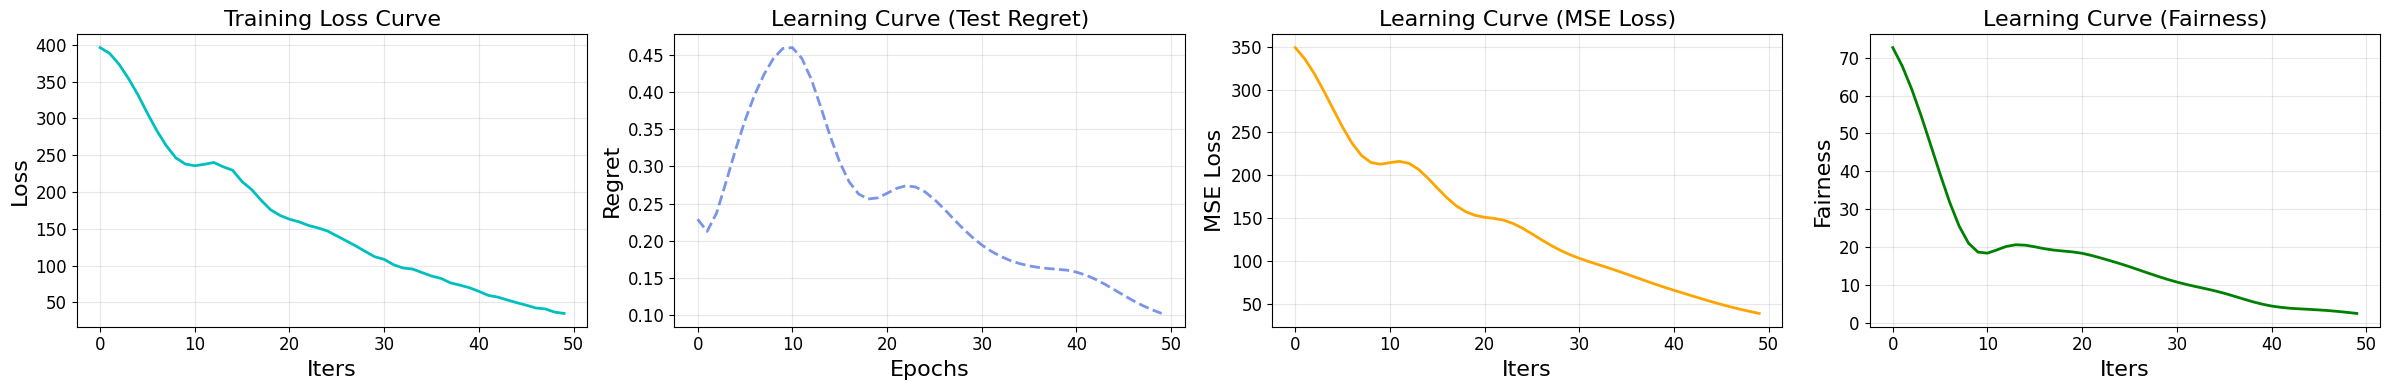

In [7]:
model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=2, Q=Q,
    lambda_fair=0,
    fairness_type="mad", 
    num_epochs=50, lr=0.005,
    group=True
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


# Evaluation

In [8]:
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

# Assume train_fair_model_logged and FairRiskPredictor are defined as before.
# Assume X_train, y_train, race_train, X_test, y_test, race_test, cost_test, Q are loaded.

def train_many_trials(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, Q,
        lambda_fair=0.0, fairness_type="none",
        num_epochs=50, lr=1e-3, batch_size=None,
        n_trials=10, base_seed=2025, group=True,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Run `train_fair_model_logged` for `n_trials` and average all results,
    including detailed group-wise metrics.
    """
    # Use a single defaultdict to store lists of final metrics from each trial
    trial_logs = defaultdict(list)

    for t in range(n_trials):
        seed = base_seed + t
        torch.manual_seed(seed)
        np.random.seed(seed)
        print(f"\n--- Trial {t+1}/{n_trials} (Seed: {seed}) ---")

        model, logs = train_fair_model_logged(
            X_train, y_train, race_train, X_test, y_test, race_test, cost_test,
            model_class, input_dim, alpha, Q,
            lambda_fair=lambda_fair, fairness_type=fairness_type,
            num_epochs=num_epochs, lr=lr, batch_size=batch_size,
            dropout_rate=dropout_rate, weight_decay=weight_decay,
            device=device, group=group
        )

        # --- Collect final metrics from the logs of the current trial ---
        # Scalar metrics
        trial_logs['regret'].append(logs['regret_log'][-1])
        trial_logs['mse'].append(logs['mse_log'][-1])
        trial_logs['fairness'].append(logs['fairness_log'][-1])
        trial_logs['training_time'].append(logs['training_time'])

        # Group-wise MSE
        for g_id, g_log in logs['per_group_mse'].items():
            if g_log: # Ensure log is not empty
                trial_logs[f'G{int(g_id)}_mse'].append(g_log[-1])

        # Group-wise decision objective (only if group=True)
        for g_id, g_log in logs['per_group_decision_objective'].items():
            if g_log: # Ensure log is not empty
                trial_logs[f'G{int(g_id)}_decision_obj'].append(g_log[-1])


    # --- Averaging and Reporting ---
    print("\n" + "="*60)
    print("      AVERAGED RESULTS ACROSS ALL TRIALS")
    print("="*60)

    avg_results = {}
    print("\n--- Overall Performance ---")
    for key in ['regret', 'mse', 'fairness', 'training_time']:
        vals = trial_logs[key]
        avg_results[key]      = np.mean(vals) if vals else np.nan
        avg_results[f'{key}_std'] = np.std(vals) if vals else np.nan
        print(f"[{key.upper():>15s}] final mean = {avg_results[key]:.4f}  |  std = {avg_results[f'{key}_std']:.4f}")

    for gkey in sorted(k for k in trial_logs if k.startswith('G')):
        vals = trial_logs[gkey]
        avg_results[gkey]          = np.mean(vals) if vals else np.nan
        avg_results[f'{gkey}_std'] = np.std(vals) if vals else np.nan
        print(f"[{gkey.upper():>15s}] final mean = {avg_results[gkey]:.4f}  |  std = {avg_results[f'{gkey}_std']:.4f}")

    return avg_results, model



In [9]:
# avg_logs = train_many_trials(
#     X_train, y_train, race_train,
#     X_test,  y_test,  race_test,
#     cost_test,
#     model_class=FairRiskPredictor,
#     input_dim=X_train.shape[1],
#     alpha=alpha, beta=beta, Q=Q,
#     lambda_fair=lambdas,
#     fairness_type="mad",
#     num_epochs=30,
#     lr=lr,
#     n_trials=2,
#     group=False
# )

# # # Visualise the averaged learning curves
# # visLearningCurve(avg_logs["loss_log"],
# #                  avg_logs["regret_log"],
# #                  avg_logs["mse_log"],
# #                  avg_logs["fairness_log"])


In [10]:
lr=1e-3

In [11]:
# =================================================================
#  MAIN EXPERIMENT LOOP
# =================================================================
# Dummy values for demonstration
epochs = 50
lr = 0.001
Q = 2500

# --- Define hyperparameter grid ---
alphas = [0.5, 2.0]
group_settings = [True, False]
fairness_types = ['atkinson', 'mad']
results_list = []

for group in group_settings:
    for fairness in fairness_types:
        if fairness == 'mad':
            fairness_lambdas = [0, 0.05, 0.5]
        elif fairness == 'atkinson':
            fairness_lambdas = [0, 1, 5]
        else:
            fairness_lambdas = [0, 1.0]

        for lam in fairness_lambdas:
            for alpha in alphas:
                run_params = {
                    'Group':    group,
                    'Alpha':    alpha,
                    'Lambda':   lam,
                    'Fairness': fairness
                }
                print("\n" + "="*70)
                print(f"RUNNING EXPERIMENT: {run_params}")
                print("="*70)

                avg_logs, model = train_many_trials(
                    X_train, y_train, race_train,
                    X_test, y_test, race_test,
                    cost_test,
                    model_class= FairRiskPredictor,
                    # model_class= LinearRegressionModel,
                    input_dim=X_train.shape[1],
                    alpha=alpha, Q=Q,
                    lambda_fair=lam,
                    fairness_type=fairness,
                    num_epochs=epochs,
                    lr=0.001,
                    n_trials=2, # Using 5 for a quick run
                    group=group
                )
                # model_name = f"model_{fairness}_{lam}_twoStage_{group}_{alpha}_NN.pth"
                # model_path = f"E:/myREPO/Fairness-Decision-Focused-Loss/Organized-FDFL/src/models/twoStage/{model_name}"
                # torch.save(model.state_dict(), model_path) # type: ignore[arg-type]

                final_run_results = run_params.copy()
                final_run_results.update(avg_logs)
                results_list.append(final_run_results)

# --- Present Final Results in a DataFrame ---
results_df = pd.DataFrame(results_list)

main_cols = ['Group','Alpha', 'Lambda', 'Fairness', 'mse' ,'fairness', 'regret']
other_cols = sorted([col for col in results_df.columns if col not in main_cols])
results_df = results_df[main_cols + other_cols]

print("\n\n" + "="*80)
print("             GRID SEARCH COMPLETE")
print("="*80)
print("\n--- Experiment Results Summary (Pandas DataFrame) ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 180):
    print(results_df)


# results_df.to_csv("2-stage-res-new-NN.csv", index=False)


RUNNING EXPERIMENT: {'Group': True, 'Alpha': 0.5, 'Lambda': 0, 'Fairness': 'atkinson'}

--- Trial 1/2 (Seed: 2025) ---

--- Trial 2/2 (Seed: 2026) ---

      AVERAGED RESULTS ACROSS ALL TRIALS

--- Overall Performance ---
[         REGRET] final mean = 0.0176  |  std = 0.0004
[            MSE] final mean = 35.4627  |  std = 1.2644
[       FAIRNESS] final mean = 0.0002  |  std = 0.0000
[  TRAINING_TIME] final mean = 1.2987  |  std = 0.0303
[G0_DECISION_OBJ] final mean = 3.9596  |  std = 0.0349
[         G0_MSE] final mean = 35.0659  |  std = 1.2405
[G1_DECISION_OBJ] final mean = 22.8149  |  std = 0.0288
[         G1_MSE] final mean = 38.5347  |  std = 1.4494

RUNNING EXPERIMENT: {'Group': True, 'Alpha': 2.0, 'Lambda': 0, 'Fairness': 'atkinson'}

--- Trial 1/2 (Seed: 2025) ---

--- Trial 2/2 (Seed: 2026) ---

      AVERAGED RESULTS ACROSS ALL TRIALS

--- Overall Performance ---
[         REGRET] final mean = 0.0983  |  std = 0.0018
[            MSE] final mean = 35.4627  |  std = 1.2644

In [14]:
results_df.to_csv(r"E:\myREPO\Fairness-Decision-Focused-Loss\Organized-FDFL\notebooks\results\res-pto-nn.csv", index=False)

In [15]:
latex_table = results_df[main_cols].to_latex(
    index=False,
    caption="Averaged Experimental Results Across Different Parameters.",
    label="tab:avg_exp_results_expanded",
    float_format="%.6f"
)

print(latex_table)

\begin{table}
\caption{Averaged Experimental Results Across Different Parameters.}
\label{tab:avg_exp_results_expanded}
\begin{tabular}{rrrlrrr}
\toprule
Group & Alpha & Lambda & Fairness & mse & fairness & regret \\
\midrule
True & 0.500000 & 0.000000 & atkinson & 35.462729 & 0.000234 & 0.017649 \\
True & 2.000000 & 0.000000 & atkinson & 35.462729 & 0.000234 & 0.098253 \\
True & 0.500000 & 1.000000 & atkinson & 35.465034 & 0.000232 & 0.017650 \\
True & 2.000000 & 1.000000 & atkinson & 35.465034 & 0.000232 & 0.098271 \\
True & 0.500000 & 5.000000 & atkinson & 35.460022 & 0.000232 & 0.017643 \\
True & 2.000000 & 5.000000 & atkinson & 35.460022 & 0.000232 & 0.098278 \\
True & 0.500000 & 0.000000 & mad & 35.462729 & 1.734385 & 0.017649 \\
True & 2.000000 & 0.000000 & mad & 35.462729 & 1.734385 & 0.098253 \\
True & 0.500000 & 0.050000 & mad & 35.369120 & 1.826815 & 0.017590 \\
True & 2.000000 & 0.050000 & mad & 35.369120 & 1.826815 & 0.097929 \\
True & 0.500000 & 0.500000 & mad & 35.267635

In [16]:
# =================================================================
#  MAIN EXPERIMENT LOOP
# =================================================================
# Dummy values for demonstration
epochs = 50
lr = 0.001
Q = 2500

# --- Define hyperparameter grid ---
alphas = [0.5, 2.0]
group_settings = [True, False]
fairness_types = ['atkinson', 'mad']
results_list = []

for group in group_settings:
    for fairness in fairness_types:
        if fairness == 'mad':
            fairness_lambdas = [0, 0.05, 0.5]
        elif fairness == 'atkinson':
            fairness_lambdas = [0, 1, 5]
        else:
            fairness_lambdas = [0, 1.0]

        for lam in fairness_lambdas:
            for alpha in alphas:
                run_params = {
                    'Group':    group,
                    'Alpha':    alpha,
                    'Lambda':   lam,
                    'Fairness': fairness
                }
                print("\n" + "="*70)
                print(f"RUNNING EXPERIMENT: {run_params}")
                print("="*70)

                avg_logs, model = train_many_trials(
                    X_train, y_train, race_train,
                    X_test, y_test, race_test,
                    cost_test,
                    # model_class= FairRiskPredictor,
                    model_class= LinearRegressionModel,
                    input_dim=X_train.shape[1],
                    alpha=alpha, Q=Q,
                    lambda_fair=lam,
                    fairness_type=fairness,
                    num_epochs=epochs,
                    lr=0.001,
                    n_trials=2, # Using 5 for a quick run
                    group=group
                )
                # model_name = f"model_{fairness}_{lam}_twoStage_{group}_{alpha}_NN.pth"
                # model_path = f"E:/myREPO/Fairness-Decision-Focused-Loss/Organized-FDFL/src/models/twoStage/{model_name}"
                # torch.save(model.state_dict(), model_path) # type: ignore[arg-type]

                final_run_results = run_params.copy()
                final_run_results.update(avg_logs)
                results_list.append(final_run_results)

# --- Present Final Results in a DataFrame ---
results_df = pd.DataFrame(results_list)

main_cols = ['Group','Alpha', 'Lambda', 'Fairness', 'mse' ,'fairness', 'regret']
other_cols = sorted([col for col in results_df.columns if col not in main_cols])
results_df = results_df[main_cols + other_cols]

print("\n\n" + "="*80)
print("             GRID SEARCH COMPLETE")
print("="*80)
print("\n--- Experiment Results Summary (Pandas DataFrame) ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 180):
    print(results_df)


# results_df.to_csv("2-stage-res-new-NN.csv", index=False)


RUNNING EXPERIMENT: {'Group': True, 'Alpha': 0.5, 'Lambda': 0, 'Fairness': 'atkinson'}

--- Trial 1/2 (Seed: 2025) ---

--- Trial 2/2 (Seed: 2026) ---

      AVERAGED RESULTS ACROSS ALL TRIALS

--- Overall Performance ---
[         REGRET] final mean = 0.1019  |  std = 0.0002
[            MSE] final mean = 208.8934  |  std = 0.8357
[       FAIRNESS] final mean = 0.0017  |  std = 0.0000
[  TRAINING_TIME] final mean = 1.0368  |  std = 0.0223
[G0_DECISION_OBJ] final mean = 3.9604  |  std = 0.0067
[         G0_MSE] final mean = 202.3406  |  std = 0.7586
[G1_DECISION_OBJ] final mean = 18.1414  |  std = 0.0060
[         G1_MSE] final mean = 259.6205  |  std = 1.4327

RUNNING EXPERIMENT: {'Group': True, 'Alpha': 2.0, 'Lambda': 0, 'Fairness': 'atkinson'}

--- Trial 1/2 (Seed: 2025) ---

--- Trial 2/2 (Seed: 2026) ---

      AVERAGED RESULTS ACROSS ALL TRIALS

--- Overall Performance ---
[         REGRET] final mean = 0.4741  |  std = 0.0048
[            MSE] final mean = 208.8934  |  std = 0.

In [17]:
results_df.to_csv(r"E:\myREPO\Fairness-Decision-Focused-Loss\Organized-FDFL\notebooks\results\res-pto-lr.csv", index=False)

In [18]:
latex_table = results_df[main_cols].to_latex(
    index=False,
    caption="Averaged Experimental Results Across Different Parameters.",
    label="tab:avg_exp_results_expanded",
    float_format="%.6f"
)

print(latex_table)

\begin{table}
\caption{Averaged Experimental Results Across Different Parameters.}
\label{tab:avg_exp_results_expanded}
\begin{tabular}{rrrlrrr}
\toprule
Group & Alpha & Lambda & Fairness & mse & fairness & regret \\
\midrule
True & 0.500000 & 0.000000 & atkinson & 208.893417 & 0.001729 & 0.101875 \\
True & 2.000000 & 0.000000 & atkinson & 208.893417 & 0.001729 & 0.474089 \\
True & 0.500000 & 1.000000 & atkinson & 208.893410 & 0.001729 & 0.101875 \\
True & 2.000000 & 1.000000 & atkinson & 208.893410 & 0.001729 & 0.474089 \\
True & 0.500000 & 5.000000 & atkinson & 208.893387 & 0.001729 & 0.101875 \\
True & 2.000000 & 5.000000 & atkinson & 208.893387 & 0.001729 & 0.474090 \\
True & 0.500000 & 0.000000 & mad & 208.893417 & 28.639977 & 0.101875 \\
True & 2.000000 & 0.000000 & mad & 208.893417 & 28.639977 & 0.474089 \\
True & 0.500000 & 0.050000 & mad & 208.875755 & 28.620609 & 0.101858 \\
True & 2.000000 & 0.050000 & mad & 208.875755 & 28.620609 & 0.474049 \\
True & 0.500000 & 0.500000 & m

In [19]:
# # Initialize the models
# model_LR = LinearRegressionModel(input_dim=X_train.shape[1])
# model_NN = FairRiskPredictor(input_dim=X_train.shape[1])

# # Load the saved weights
# model_LR.load_state_dict(torch.load("2-stage-pred-model-LR.pth"))
# model_NN.load_state_dict(torch.load("2-stage-pred-model-NN.pth"))

# model_LR.eval()
# model_NN.eval()